# Assignment 4
## Econ 8310 - Business Forecasting

This assignment will make use of the bayesian statistical models covered in Lessons 10 to 12. 

A/B Testing is a critical concept in data science, and for many companies one of the most relevant applications of data-driven decision-making. In order to improve product offerings, marketing campaigns, user interfaces, and many other user-facing interactions, scientists and engineers create experiments to determine the efficacy of proposed changes. Users are then randomly assigned to either the treatment or control group, and their behavior is recorded.
If the changes that the treatment group is exposed to can be measured to have a benefit in the metric of interest, then those changes are scaled up and rolled out to across all interactions.
Below is a short video detailing the A/B Testing process, in case you want to learn a bit more:
[https://youtu.be/DUNk4GPZ9bw](https://youtu.be/DUNk4GPZ9bw)

For this assignment, you will use an A/B test data set, which was pulled from the Kaggle website (https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing). I have added the data from the page into Codio for you. It can be found in the cookie_cats.csv file in the file tree. It can also be found at [https://github.com/dustywhite7/Econ8310/raw/master/AssignmentData/cookie_cats.csv](https://github.com/dustywhite7/Econ8310/raw/master/AssignmentData/cookie_cats.csv)

The variables are defined as follows:

| Variable Name  | Definition |
|----------------|----|
| userid         | A unique number that identifies each player  |
| version        | Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40) |
| sum_gamerounds | The number of game rounds played by the player during the first 14 days after install.  |
| retention1     | Did the player come back and play 1 day after installing?     |
| retention7     | Did the player come back and play 7 days after installing?    |               

### The questions

You will be asked to answer the following questions in a small quiz on Canvas:
1. What was the effect of moving the gate from level 30 to level 40 on 1-day retention rates?
2. What was the effect of moving the gate from level 30 to level 40 on 7-day retention rates?
3. What was the biggest challenge for you in completing this assignment?

You will also be asked to submit a URL to your forked GitHub repository containing your code used to answer these questions.

Initializing NUTS using jitter+adapt_diag...


Dataset Overview:
--------------------------------------------------
Total Samples: 90189
Versions Distribution:
version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

Retention Rates:
         retention_1  retention_7
version                          
gate_30     0.448188     0.190201
gate_40     0.442283     0.182000
1-DAY RETENTION ANALYSIS


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_30_retention_1, p_40_retention_1]


Output()

Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 55 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


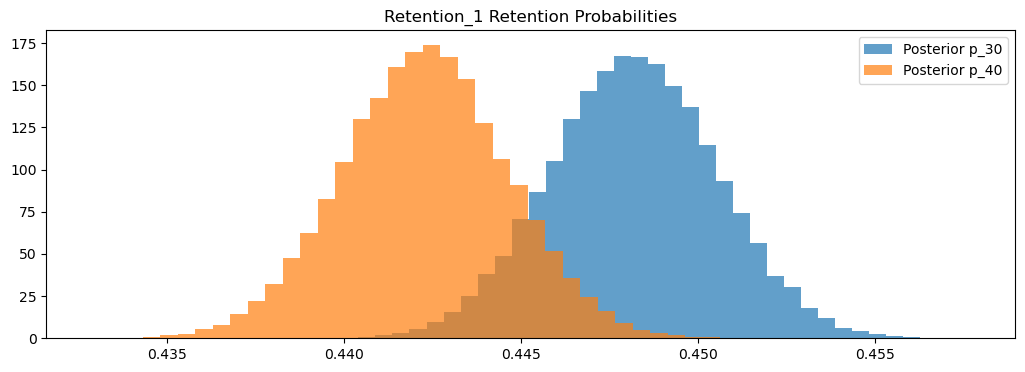

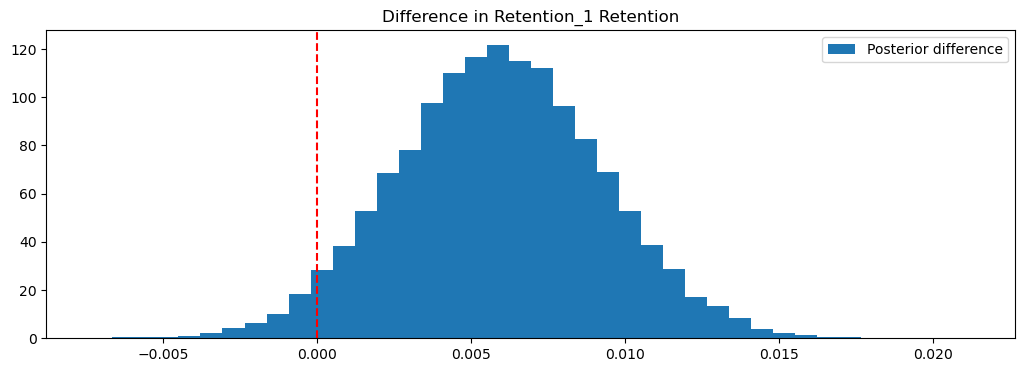


Retention_1 Retention Analysis:
                   mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
p_30_retention_1  0.448  0.002     0.444      0.453        0.0      0.0   
p_40_retention_1  0.442  0.002     0.438      0.447        0.0      0.0   
difference        0.006  0.003    -0.001      0.012        0.0      0.0   

                  ess_bulk  ess_tail  r_hat  
p_30_retention_1   41565.0   30388.0    1.0  
p_40_retention_1   40340.0   29693.0    1.0  
difference         41517.0   28574.0    1.0  

Probability that Gate_30 is Superior: 96.37%
7-DAY RETENTION ANALYSIS


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_30_retention_7, p_40_retention_7]


Output()

Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 41 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


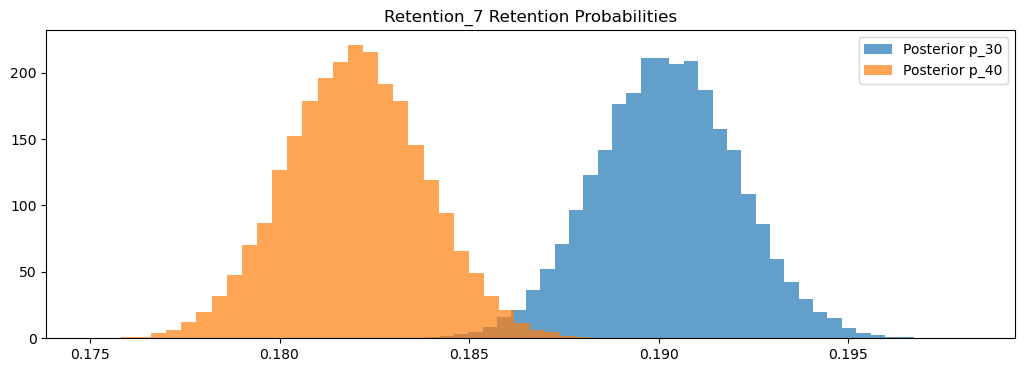

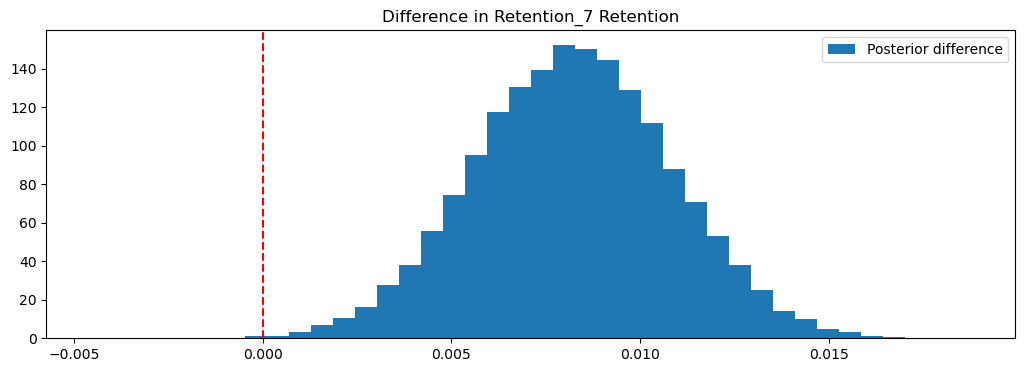


Retention_7 Retention Analysis:
                   mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
p_30_retention_7  0.190  0.002     0.187      0.194        0.0      0.0   
p_40_retention_7  0.182  0.002     0.178      0.186        0.0      0.0   
difference        0.008  0.003     0.003      0.013        0.0      0.0   

                  ess_bulk  ess_tail  r_hat  
p_30_retention_7   43705.0   29372.0    1.0  
p_40_retention_7   44573.0   30969.0    1.0  
difference         44152.0   30226.0    1.0  

Probability that Gate_30 is Superior: 99.93%


In [2]:
import pandas as pd
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

def load_and_analyze_data(file_path):
    # Load data
    data = pd.read_csv(file_path)
    
    # Data Overview
    print("Dataset Overview:")
    print("-" * 50)
    print(f"Total Samples: {len(data)}")
    print(f"Versions Distribution:\n{data['version'].value_counts()}")
    
    # Retention Summary
    retention_summary = data.groupby('version')[['retention_1', 'retention_7']].mean()
    print("\nRetention Rates:")
    print(retention_summary)
    
   
    def run_retention_analysis(retention_type):
        gate_30_retention = data[data['version'] == 'gate_30'][retention_type]
        gate_40_retention = data[data['version'] == 'gate_40'][retention_type]
        
        with pm.Model() as retention_model:
            p_30 = pm.Uniform(f'p_30_{retention_type}', lower=0, upper=1)
            p_40 = pm.Uniform(f'p_40_{retention_type}', lower=0, upper=1)
            
            obs_30 = pm.Bernoulli(f'obs_30_{retention_type}', p=p_30, observed=gate_30_retention)
            obs_40 = pm.Bernoulli(f'obs_40_{retention_type}', p=p_40, observed=gate_40_retention)
            
            difference = pm.Deterministic('difference', p_30 - p_40)
            
            trace = pm.sample(20000, chains=2)
        
        return trace
    
    # Visualization Function
    def visualize_retention_analysis(trace, retention_type):
        # Posterior Distributions for Gate Probabilities
        plt.figure(figsize=(12.5, 4))
        
        p_30_samples = np.concatenate(trace.posterior[f'p_30_{retention_type}'].data[:,1000:])
        p_40_samples = np.concatenate(trace.posterior[f'p_40_{retention_type}'].data[:,1000:])
        
        plt.hist(p_30_samples, bins=40, label='Posterior p_30', density=True, alpha=0.7)
        plt.hist(p_40_samples, bins=40, label='Posterior p_40', density=True, alpha=0.7)
        plt.title(f'{retention_type.capitalize()} Retention Probabilities')
        plt.legend()
        plt.show()
        
        
        difference_samples = np.concatenate(trace.posterior['difference'].data[:,1000:])
        
        plt.figure(figsize=(12.5, 4))
        plt.hist(difference_samples, bins=40, label='Posterior difference', density=True)
        plt.title(f'Difference in {retention_type.capitalize()} Retention')
        plt.axvline(x=0, color='r', linestyle='--')
        plt.legend()
        plt.show()
        
        # Print Summary
        print(f"\n{retention_type.capitalize()} Retention Analysis:")
        print(az.summary(trace, hdi_prob=0.95))
        
        # Probability of Superiority
        prob_superior = np.mean(difference_samples > 0)
        print(f"\nProbability that Gate_30 is Superior: {prob_superior:.2%}")
        
        return prob_superior
    
   
    print("1-DAY RETENTION ANALYSIS")
    trace_1day = run_retention_analysis('retention_1')
    prob_1day = visualize_retention_analysis(trace_1day, 'retention_1')
    
    print("7-DAY RETENTION ANALYSIS")
    trace_7day = run_retention_analysis('retention_7')
    prob_7day = visualize_retention_analysis(trace_7day, 'retention_7')
if __name__ == "__main__":
    file_path = "https://raw.githubusercontent.com/dustywhite7/Econ8310/master/AssignmentData/cookie_cats.csv"
    load_and_analyze_data(file_path)